<a href="https://colab.research.google.com/github/suyeonb/AI_lab_baesuyeon/blob/main/week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===== 10주차 과제: EfficientNet Transfer Learning on Hymenoptera =====
# - 데이터셋: hymenoptera_data (ants / bees)
# - 모델: EfficientNet (ImageNet 사전학습 가중치 사용)
# - 목표: 학습 로그(손실 / 정확도) 출력 + 예측 결과 시각화

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
from PIL import Image

cudnn.benchmark = True
plt.ion()  # 그림을 바로바로 보고 싶을 때 켜두는 옵션

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 디바이스:", device)

사용 디바이스: cuda


In [7]:
import os
import zipfile

# 1. Colab에 올려둔 zip 절대 경로
zip_path = "/content/hymenoptera_data.zip"

# 2. 압축 풀 위치
extract_dir = "/content/hymenoptera_data"

# 압축 풀기
if not os.path.exists(extract_dir):
    print("압축 푸는 중...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("압축 풀기 완료!")
else:
    print("이미 폴더가 존재합니다:", extract_dir)

# 경로 확인
data_dir = "/content/hymenoptera_data/hymenoptera_data"
print("데이터 경로:", data_dir)
print("train 폴더:", os.listdir(os.path.join(data_dir, 'train')))
print("val 폴더:", os.listdir(os.path.join(data_dir, 'val')))



이미 폴더가 존재합니다: /content/hymenoptera_data
데이터 경로: /content/hymenoptera_data/hymenoptera_data
train 폴더: ['ants', 'bees']
val 폴더: ['ants', 'bees']


In [8]:
# ===== 데이터 전처리 & 증강 =====
# - train: 데이터 증강 + 정규화
# - val  : 정규화만

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),      # 이미지를 랜덤 크롭 후 224x224로
        transforms.RandomHorizontalFlip(),      # 좌우 반전
        transforms.ToTensor(),                  # Tensor로 변환
        transforms.Normalize(                   # ImageNet 통계 기준 정규화
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),                 # 긴 변 기준 256으로 리사이즈
        transforms.CenterCrop(224),             # 중앙 224x224 크롭
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ]),
}

# ImageFolder 사용해서 train/val 세트 만들기
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        data_transforms[x]
    )
    for x in ['train', 'val']
}

# DataLoader: 배치로 묶어 학습에 사용
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=8,
        shuffle=True if x == 'train' else False,
        num_workers=2
    )
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print("클래스:", class_names)
print("train 개수:", dataset_sizes['train'])
print("val   개수:", dataset_sizes['val'])


클래스: ['ants', 'bees']
train 개수: 244
val   개수: 153


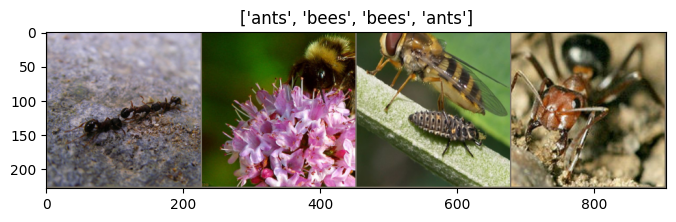

In [9]:
# Tensor 이미지를 실제 이미지처럼 보여주는 작은 함수
def imshow(inp, title=None):
    """Tensor 이미지를 화면에 보여주는 함수"""
    inp = inp.numpy().transpose((1, 2, 0))  # (C,H,W) -> (H,W,C)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean                 # 정규화 되돌리기
    inp  = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)  # 잠깐 멈춰서 그림 보이게 하기

# 몇 장만 확인
inputs, classes_idx = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:4])

plt.figure(figsize=(8, 4))
imshow(out, title=[class_names[x] for x in classes_idx[:4]])


In [11]:
# ===== 학습 루프 함수 =====
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    """
    - train / val 두 phase를 번갈아 돌면서
      loss / accuracy를 출력하고, val 기준 best 모델을 저장하는 함수.
    """
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\n===== Epoch {epoch+1}/{num_epochs} =====')

        # 각 epoch마다 training / validation 단계 수행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # 학습 모드
            else:
                model.eval()    # 평가 모드

            running_loss = 0.0
            running_corrects = 0

            # 미니배치 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매 step마다 gradient 초기화
                optimizer.zero_grad()

                # forward
                # train일 때만 gradient 계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + 최적화 (train phase에서만)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계 값 누적
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase:5s}  Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}')

            # 가장 성능 좋은 모델 업데이트 (val 기준)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(f'\n학습 완료! 총 소요 시간: {time_elapsed // 60:.0f}분 {time_elapsed % 60:.0f}초')
    print(f'최고 val 정확도: {best_acc:.4f}')

    # best 모델 가중치 로드
    model.load_state_dict(best_model_wts)
    return model


# ===== 예측 결과 시각화 함수 (여러 장) =====
def visualize_model(model, num_images=6):
    """
    val 데이터에서 몇 장 뽑아서
    - 예측 라벨을 제목으로 붙여서 그려주는 함수
    """
    was_training = model.training
    model.eval()
    images_so_far = 0

    plt.figure(figsize=(10, 6))

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images // 3 + 1, 3, images_so_far)
                ax.axis('off')
                ax.set_title(f'pred: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [12]:
# ===== EfficientNet 사전학습 모델 불러오기 =====
# torchvision 최신 버전 기준 (B0 사용)
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# ImageNet으로 학습된 가중치 로드
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model_conv = efficientnet_b0(weights=weights)

# feature extractor는 동결 (백본은 고정, classifier만 학습)
for param in model_conv.features.parameters():
    param.requires_grad = False

# 출력 클래스 수를 2개(ants / bees)로 변경
num_ftrs = model_conv.classifier[1].in_features
model_conv.classifier[1] = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

# 손실 함수 & optimizer & scheduler 설정
criterion = nn.CrossEntropyLoss()

# classifier 파라미터만 학습
optimizer_conv = optim.SGD(
    model_conv.classifier.parameters(),
    lr=0.001,
    momentum=0.9
)

# learning rate 스케줄러 (7 epoch마다 lr 0.1배)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print(model_conv.classifier)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 234MB/s]


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


In [13]:
# ===== EfficientNet 사전학습 모델 불러오기 =====
# torchvision 최신 버전 기준 (B0 사용)
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# ImageNet으로 학습된 가중치 로드
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model_conv = efficientnet_b0(weights=weights)

# feature extractor는 동결 (백본은 고정, classifier만 학습)
for param in model_conv.features.parameters():
    param.requires_grad = False

# 출력 클래스 수를 2개(ants / bees)로 변경
num_ftrs = model_conv.classifier[1].in_features
model_conv.classifier[1] = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

# 손실 함수 & optimizer & scheduler 설정
criterion = nn.CrossEntropyLoss()

# classifier 파라미터만 학습 (효율적인 미세조정)
optimizer_conv = optim.SGD(
    model_conv.classifier.parameters(),
    lr=0.001,
    momentum=0.9
)

# learning rate 스케줄러 (7 epoch마다 lr 0.1배)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print(model_conv.classifier)


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


In [14]:
num_epochs = 10

model_conv = train_model(
    model_conv,
    criterion,
    optimizer_conv,
    exp_lr_scheduler,
    num_epochs=num_epochs
)



===== Epoch 1/10 =====
train  Loss: 0.6484  Acc: 0.6107
val    Loss: 0.4958  Acc: 0.8824

===== Epoch 2/10 =====
train  Loss: 0.4600  Acc: 0.8402
val    Loss: 0.3781  Acc: 0.8889

===== Epoch 3/10 =====
train  Loss: 0.4381  Acc: 0.8402
val    Loss: 0.3185  Acc: 0.9216

===== Epoch 4/10 =====
train  Loss: 0.3802  Acc: 0.8607
val    Loss: 0.2831  Acc: 0.9216

===== Epoch 5/10 =====
train  Loss: 0.3385  Acc: 0.8770
val    Loss: 0.2694  Acc: 0.9346

===== Epoch 6/10 =====
train  Loss: 0.3549  Acc: 0.8525
val    Loss: 0.2525  Acc: 0.9216

===== Epoch 7/10 =====
train  Loss: 0.3185  Acc: 0.8607
val    Loss: 0.2419  Acc: 0.9542

===== Epoch 8/10 =====
train  Loss: 0.3573  Acc: 0.8689
val    Loss: 0.2406  Acc: 0.9477

===== Epoch 9/10 =====
train  Loss: 0.2878  Acc: 0.9139
val    Loss: 0.2207  Acc: 0.9412

===== Epoch 10/10 =====
train  Loss: 0.3247  Acc: 0.8484
val    Loss: 0.2366  Acc: 0.9477

학습 완료! 총 소요 시간: 0분 33초
최고 val 정확도: 0.9542


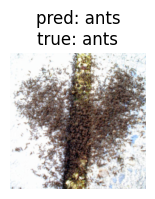

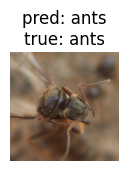

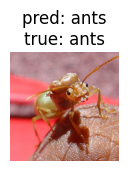

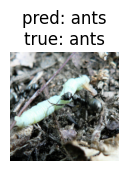

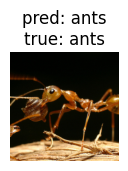

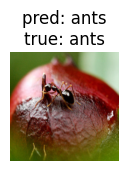

In [15]:
visualize_model(model_conv, num_images=6)
plt.ioff()
plt.show()

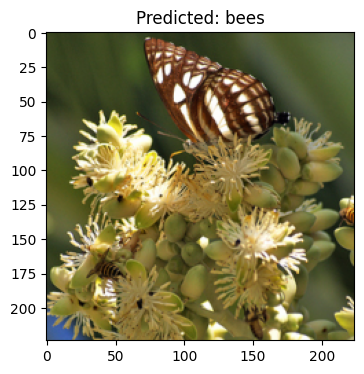

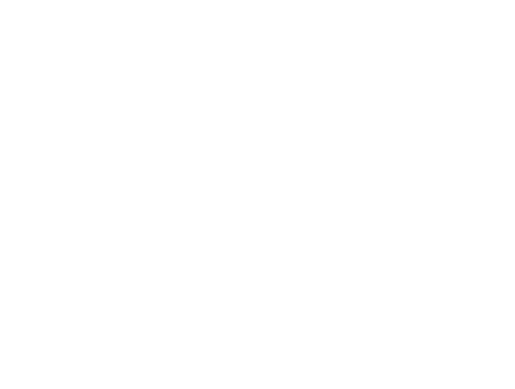

In [16]:
# val 데이터셋의 이미지 중 한 장을 골라서 직접 예측해보는 함수
def visualize_model_predictions(model, img_path):
    """
    img_path에 있는 이미지를 불러와서
    - transforms 적용 후
    - 예측 결과와 함께 시각화
    """
    model.eval()

    # 이미지 불러오기
    img = Image.open(img_path).convert('RGB')
    img_t = data_transforms['val'](img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(4, 4))
    plt.title(f'Predicted: {class_names[preds[0]]}')
    imshow(img_t.cpu().data[0])
    plt.axis('off')
    plt.show()


# 예시: bees 한 장
sample_img_path = os.path.join(
    data_dir,
    'val',
    'bees',
    '72100438_73de9f17af.jpg'
)

visualize_model_predictions(model_conv, img_path=sample_img_path)
